In [13]:
 from sklearn.datasets import fetch_openml
 data = fetch_openml(name='adult', version=2, as_frame=True)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

In [15]:
class DataPreprocessor:

    def __init__(self):
        self.scaler = None
        self.encoders = {}
        self.feature_names = None

    def load_data(self):
        X, y = data.data, data.target
        y = (y == '>50K').astype(int)
        print(f"Target distribution: {np.bincount(y)}")
        return X, y

    def handle_missing_values(self, X):

        X['workclass'] = X['workclass'].cat.add_categories('Unknown')
        X['occupation'] = X['occupation'].cat.add_categories('Unknown')

        mask = X['workclass'].isnull() & X['occupation'].isnull()
        X.loc[mask, 'workclass'] = 'Unknown'
        X.loc[mask, 'occupation'] = 'Unknown'

        X['occupation'] = X.groupby('workclass')['occupation'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
        )

        X['native-country'] = X['native-country'].cat.add_categories('Unknown').fillna('Unknown')

        return X



    def encode_categorical_features(self, X_train, X_val, X_test, threshold=10):
        categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
        numerical_cols = X_train.select_dtypes(exclude=['object', 'category']).columns

        X_train_encoded = X_train[numerical_cols].copy()
        X_val_encoded = X_val[numerical_cols].copy()
        X_test_encoded = X_test[numerical_cols].copy()

        for col in categorical_cols:
            num_unique = X_train[col].nunique()

            if num_unique > threshold:
                le = LabelEncoder()
                X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
                X_val_encoded[col] = le.transform(X_val[col].astype(str))
                X_test_encoded[col] = le.transform(X_test[col].astype(str))
                self.encoders[col] = le

            else:
                dummies_train = pd.get_dummies(X_train[col], prefix=col, drop_first=True)
                dummies_val = pd.get_dummies(X_val[col], prefix=col, drop_first=True)
                dummies_test = pd.get_dummies(X_test[col], prefix=col, drop_first=True)

                dummies_val = dummies_val.reindex(columns=dummies_train.columns, fill_value=0)
                dummies_test = dummies_test.reindex(columns=dummies_train.columns, fill_value=0)

                X_train_encoded = pd.concat([X_train_encoded, dummies_train], axis=1)
                X_val_encoded = pd.concat([X_val_encoded, dummies_val], axis=1)
                X_test_encoded = pd.concat([X_test_encoded, dummies_test], axis=1)

        return X_train_encoded, X_val_encoded, X_test_encoded


    def scale_features(self, X_train, X_val, X_test, method='standard'):

        if method == 'standard':
            self.scaler = StandardScaler()
        elif method == 'minmax':
            self.scaler = MinMaxScaler()
        elif method == 'robust':
            self.scaler = RobustScaler()
        else:
            return X_train, X_val, X_test

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        return X_train_scaled, X_val_scaled, X_test_scaled


In [16]:
class FeedforwardNN(nn.Module):

    def __init__(self, input_size, hidden_sizes, activation='relu', dropout_rate=0.2, use_batchnorm=False):
        super(FeedforwardNN, self).__init__()

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList() if use_batchnorm else None
        self.dropout = nn.Dropout(dropout_rate)
        self.use_batchnorm = use_batchnorm

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU()

        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(prev_size, hidden_size))
            if use_batchnorm:
                self.batch_norms.append(nn.BatchNorm1d(hidden_size))
            prev_size = hidden_size

        self.output_layer = nn.Linear(prev_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batchnorm:
                x = self.batch_norms[i](x)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.output_layer(x)
        return self.sigmoid(x)

class ModelTrainer:

    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, train_loader, optimizer, criterion):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y.float()).sum().item()

        return total_loss / len(train_loader), correct / total

    def evaluate(self, data_loader, criterion):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for batch_x, batch_y in data_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)

                outputs = self.model(batch_x)
                loss = criterion(outputs.squeeze(), batch_y.float())

                total_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y.float()).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(batch_y.cpu().numpy())

        return total_loss / len(data_loader), correct / total, all_predictions, all_targets

    def train(self, train_loader, val_loader, optimizer, criterion, epochs=100, early_stopping_patience=10):
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            val_loss, val_acc, _, _ = self.evaluate(val_loader, criterion)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            if epoch % 10 == 0:
                print(f'Epoch {epoch:3d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
                      f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch}')
                    break

        self.model.load_state_dict(torch.load('best_model.pth'))
        return self.model

In [22]:
class ExperimentRunner:

    def __init__(self):
        self.results = []
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def preprocessing_ablation(self, X, y):

        preprocessing_configs = [
            {'scaling': 'standard'},
            {'scaling': 'minmax'},
            {'scaling': 'robust'}
        ]

        preprocessing_results = []

        for config in preprocessing_configs:
            print(f"\nTesting: {config}")

            X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

            preprocessor = DataPreprocessor()
            X_train = preprocessor.handle_missing_values(X_train)
            X_val = preprocessor.handle_missing_values(X_val)
            X_test = preprocessor.handle_missing_values(X_test)

            X_train_enc, X_val_enc, X_test_enc = preprocessor.encode_categorical_features(
                X_train, X_val, X_test)

            X_train_final, X_val_final, X_test_final = preprocessor.scale_features(
                X_train_enc, X_val_enc, X_test_enc, method=config['scaling'])

            X_train_tensor = torch.FloatTensor(X_train_final)
            X_val_tensor = torch.FloatTensor(X_val_final)
            y_train_tensor = torch.LongTensor(y_train.values)
            y_val_tensor = torch.LongTensor(y_val.values)

            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

            model = FeedforwardNN(X_train_final.shape[1], [128, 64], activation='relu', dropout_rate=0.2)
            trainer = ModelTrainer(model, self.device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.BCELoss()

            trained_model = trainer.train(train_loader, val_loader, optimizer, criterion, epochs=50, early_stopping_patience=5)

            _, val_acc, _, _ = trainer.evaluate(val_loader, criterion)

            result = {
                'config': config,
                'val_accuracy': val_acc,
                'scaling': config['scaling']
            }
            preprocessing_results.append(result)
            print(f"Validation Accuracy: {val_acc:.4f}")

        best_preprocessing = max(preprocessing_results, key=lambda x: x['val_accuracy'])
        print(f"\nBest preprocessing: {best_preprocessing['config']} with accuracy: {best_preprocessing['val_accuracy']:.4f}")

        return best_preprocessing['config'], preprocessing_results

    def architecture_ablation(self, X_train_final, X_val_final, y_train, y_val):

        architectures = [
            {'hidden_sizes': [64], 'activation': 'relu'},
            {'hidden_sizes': [128], 'activation': 'relu'},
            {'hidden_sizes': [64, 32], 'activation': 'relu'},
            {'hidden_sizes': [128, 64], 'activation': 'relu'},
            {'hidden_sizes': [256, 128, 64], 'activation': 'relu'},
            {'hidden_sizes': [128, 64], 'activation': 'tanh'},
            {'hidden_sizes': [128, 64], 'activation': 'leakyrelu'},
        ]

        architecture_results = []

        for arch in architectures:
            print(f"\nTesting architecture: {arch}")


            X_train_tensor = torch.FloatTensor(X_train_final)
            X_val_tensor = torch.FloatTensor(X_val_final)
            y_train_tensor = torch.LongTensor(y_train.values)
            y_val_tensor = torch.LongTensor(y_val.values)


            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


            model = FeedforwardNN(
                X_train_final.shape[1],
                arch['hidden_sizes'],
                activation=arch['activation'],
                dropout_rate=0.2
            )
            trainer = ModelTrainer(model, self.device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.BCELoss()

            trained_model = trainer.train(train_loader, val_loader, optimizer, criterion, epochs=50, early_stopping_patience=5)

            _, val_acc, _, _ = trainer.evaluate(val_loader, criterion)

            result = {
                'architecture': arch,
                'val_accuracy': val_acc,
                'num_params': sum(p.numel() for p in model.parameters())
            }
            architecture_results.append(result)
            print(f"Validation Accuracy: {val_acc:.4f}, Parameters: {result['num_params']}")

        best_arch = max(architecture_results, key=lambda x: x['val_accuracy'])
        print(f"\nBest architecture: {best_arch['architecture']} with accuracy: {best_arch['val_accuracy']:.4f}")

        return best_arch['architecture'], architecture_results

    def optimizer_ablation(self, X_train_final, X_val_final, y_train, y_val, best_arch):

        configs = [
            {'optimizer': 'Adam', 'lr': 0.001, 'loss': 'BCE'},
            {'optimizer': 'Adam', 'lr': 0.01, 'loss': 'BCE'},
            {'optimizer': 'Adam', 'lr': 0.0001, 'loss': 'BCE'},
            {'optimizer': 'SGD', 'lr': 0.01, 'loss': 'BCE'},
            {'optimizer': 'RMSprop', 'lr': 0.001, 'loss': 'BCE'},
            {'optimizer': 'Adam', 'lr': 0.001, 'loss': 'BCEWithLogits'},
        ]

        optimizer_results = []

        for config in configs:
            print(f"\nTesting: {config}")

            X_train_tensor = torch.FloatTensor(X_train_final)
            X_val_tensor = torch.FloatTensor(X_val_final)
            y_train_tensor = torch.LongTensor(y_train.values)
            y_val_tensor = torch.LongTensor(y_val.values)

            print(f"X_train_final shape: {X_train_final.shape}")
            print(f"X_val_final shape: {X_val_final.shape}")
            print(f"Model input size: {X_train_final.shape[1]}")

            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)



            if config['loss'] == 'BCEWithLogits':

                model = FeedforwardNN(
                    X_train_final.shape[1],
                    best_arch['hidden_sizes'],
                    activation=best_arch['activation'],
                    dropout_rate=0.2
                )

                model.forward = lambda x: model.output_layer(model.dropout(model.activation(model.layers[-1](x))))
                criterion = nn.BCEWithLogitsLoss()
            else:
                model = FeedforwardNN(
                    X_train_final.shape[1],
                    best_arch['hidden_sizes'],
                    activation=best_arch['activation'],
                    dropout_rate=0.2
                )
                criterion = nn.BCELoss()


            print(f"First layer input features: {model.layers[0].in_features}")
            print(f"First layer output features: {model.layers[0].out_features}")

            if config['optimizer'] == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=config['lr'])
            elif config['optimizer'] == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=config['lr'])
            elif config['optimizer'] == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])

            trainer = ModelTrainer(model, self.device)
            trained_model = trainer.train(train_loader, val_loader, optimizer, criterion, epochs=50, early_stopping_patience=5)

            _, val_acc, _, _ = trainer.evaluate(val_loader, criterion)

            result = {
                'config': config,
                'val_accuracy': val_acc
            }
            optimizer_results.append(result)
            print(f"Validation Accuracy: {val_acc:.4f}")

        best_optimizer = max(optimizer_results, key=lambda x: x['val_accuracy'])
        print(f"\nBest optimizer config: {best_optimizer['config']} with accuracy: {best_optimizer['val_accuracy']:.4f}")

        return best_optimizer['config'], optimizer_results

    def regularization_ablation(self, X_train_final, X_val_final, y_train, y_val, best_arch, best_optimizer):

        reg_configs = [
            {'dropout': 0.0, 'weight_decay': 0.0, 'batchnorm': False},
            {'dropout': 0.2, 'weight_decay': 0.0, 'batchnorm': False},
            {'dropout': 0.5, 'weight_decay': 0.0, 'batchnorm': False},
            {'dropout': 0.7, 'weight_decay': 0.0, 'batchnorm': False},
            {'dropout': 0.2, 'weight_decay': 1e-4, 'batchnorm': False},
            {'dropout': 0.2, 'weight_decay': 1e-3, 'batchnorm': False},
            {'dropout': 0.2, 'weight_decay': 0.0, 'batchnorm': True},
            {'dropout': 0.2, 'weight_decay': 1e-4, 'batchnorm': True},
        ]

        regularization_results = []

        for reg_config in reg_configs:
            print(f"\nTesting regularization: {reg_config}")

            X_train_tensor = torch.FloatTensor(X_train_final)
            X_val_tensor = torch.FloatTensor(X_val_final)
            y_train_tensor = torch.LongTensor(y_train.values)
            y_val_tensor = torch.LongTensor(y_val.values)

            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

            model = FeedforwardNN(
                X_train_final.shape[1],
                best_arch['hidden_sizes'],
                activation=best_arch['activation'],
                dropout_rate=reg_config['dropout'],
                use_batchnorm=reg_config['batchnorm']
            )


            if best_optimizer['optimizer'] == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=best_optimizer['lr'], weight_decay=reg_config['weight_decay'])
            elif best_optimizer['optimizer'] == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=best_optimizer['lr'], weight_decay=reg_config['weight_decay'])
            elif best_optimizer['optimizer'] == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=best_optimizer['lr'], weight_decay=reg_config['weight_decay'])

            criterion = nn.BCELoss()

            trainer = ModelTrainer(model, self.device)
            trained_model = trainer.train(train_loader, val_loader, optimizer, criterion, epochs=50, early_stopping_patience=5)


            _, val_acc, _, _ = trainer.evaluate(val_loader, criterion)

            result = {
                'config': reg_config,
                'val_accuracy': val_acc
            }
            regularization_results.append(result)
            print(f"Validation Accuracy: {val_acc:.4f}")

        best_reg = max(regularization_results, key=lambda x: x['val_accuracy'])
        print(f"\nBest regularization: {best_reg['config']} with accuracy: {best_reg['val_accuracy']:.4f}")

        return best_reg['config'], regularization_results

def plot_results(trainer, title="Training Results"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(trainer.train_losses, label='Training Loss', color='blue')
    ax1.plot(trainer.val_losses, label='Validation Loss', color='red')
    ax1.set_title(f'{title} - Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)


    ax2.plot(trainer.train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(trainer.val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title(f'{title} - Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
def evaluate_model_comprehensive(model, test_loader, class_names=['<=50K', '>50K']):
    model.eval()
    all_predictions = []
    all_targets = []
    all_probabilities = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            probabilities = outputs.squeeze().cpu().numpy()
            predicted = (probabilities > 0.5).astype(int)

            all_predictions.extend(predicted)
            all_targets.extend(batch_y.cpu().numpy())
            all_probabilities.extend(probabilities)


    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)

    print("MODEL EVALUATION RESULTS")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nDetailed Classification Report:")
    print(classification_report(all_targets, all_predictions, target_names=class_names))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities
    }


=== NEURAL NETWORK INCOME CLASSIFICATION ===
Building a complete neural network from scratch using PyTorch
Using device: cpu
Target distribution: [37155 11687]

Testing: {'scaling': 'standard'}
Epoch   0: Train Loss: 0.3664, Val Loss: 0.3263, Train Acc: 0.8280, Val Acc: 0.8456
Epoch  10: Train Loss: 0.3109, Val Loss: 0.3195, Train Acc: 0.8554, Val Acc: 0.8473
Early stopping at epoch 14
Validation Accuracy: 0.8454

Testing: {'scaling': 'minmax'}
Epoch   0: Train Loss: 0.4224, Val Loss: 0.3609, Train Acc: 0.7984, Val Acc: 0.8336
Epoch  10: Train Loss: 0.3188, Val Loss: 0.3220, Train Acc: 0.8503, Val Acc: 0.8419
Epoch  20: Train Loss: 0.3132, Val Loss: 0.3201, Train Acc: 0.8550, Val Acc: 0.8462
Epoch  30: Train Loss: 0.3096, Val Loss: 0.3217, Train Acc: 0.8554, Val Acc: 0.8433
Early stopping at epoch 30
Validation Accuracy: 0.8463

Testing: {'scaling': 'robust'}
Epoch   0: Train Loss: 4.9742, Val Loss: 5.9153, Train Acc: 0.7846, Val Acc: 0.8080
Epoch  10: Train Loss: 3.3663, Val Loss: 3.6

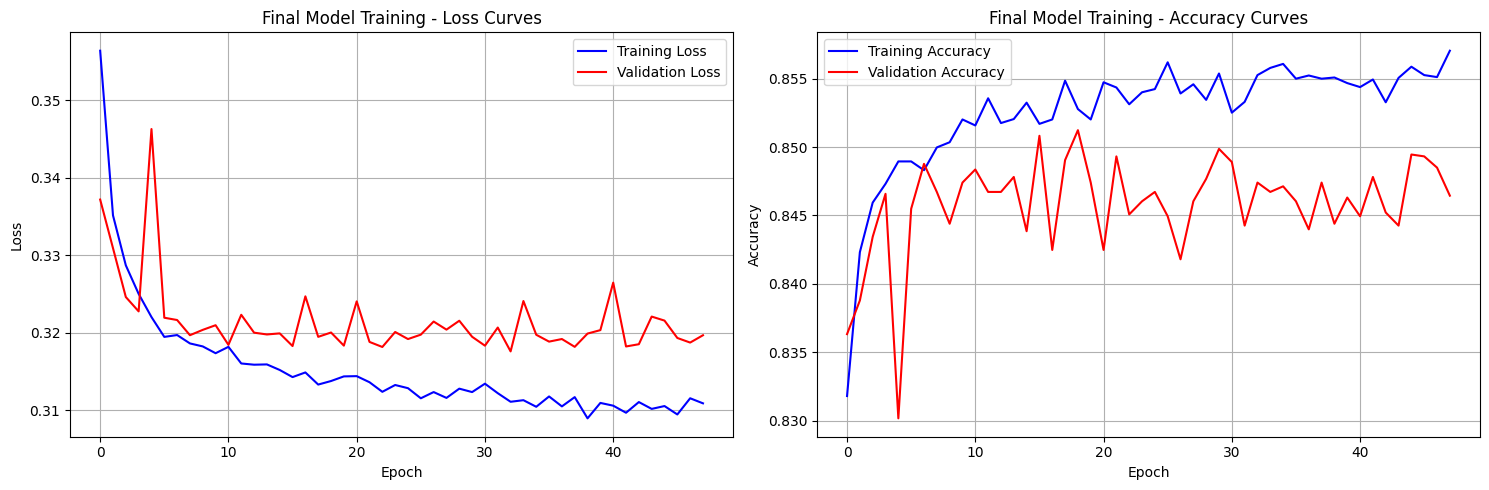


=== MODEL EVALUATION RESULTS ===
Accuracy:  0.8574
Precision: 0.7550
Recall:    0.5978
F1-Score:  0.6673


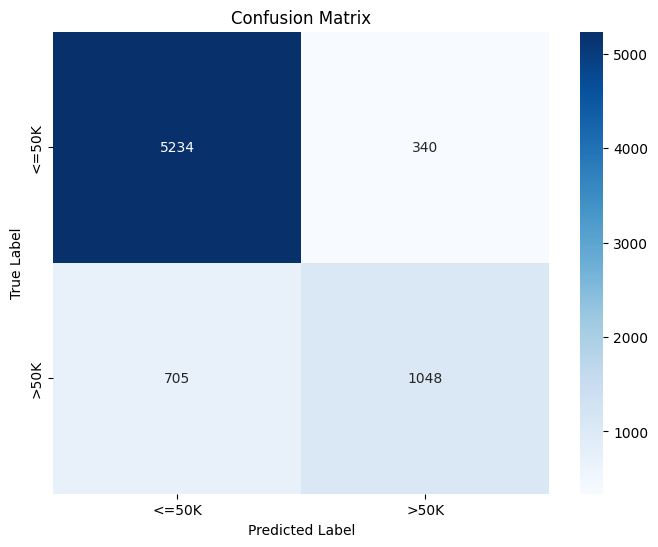


Detailed Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      5574
        >50K       0.76      0.60      0.67      1753

    accuracy                           0.86      7327
   macro avg       0.82      0.77      0.79      7327
weighted avg       0.85      0.86      0.85      7327


=== HYPERPARAMETER TUNING SUMMARY ===

Preprocessing Results:
    scaling  val_accuracy
1    minmax      0.846312
0  standard      0.845354
2    robust      0.811551

Architecture Results:
     hidden_sizes activation  val_accuracy  num_params
1           [128]       relu      0.847270        4481
2        [64, 32]       relu      0.847270        4289
0            [64]       relu      0.844669        2241
4  [256, 128, 64]       relu      0.843575       49921
6       [128, 64]  leakyrelu      0.842617       12673
5       [128, 64]       tanh      0.841659       12673
3       [128, 64]       relu      0.841385       12673

Optimizer

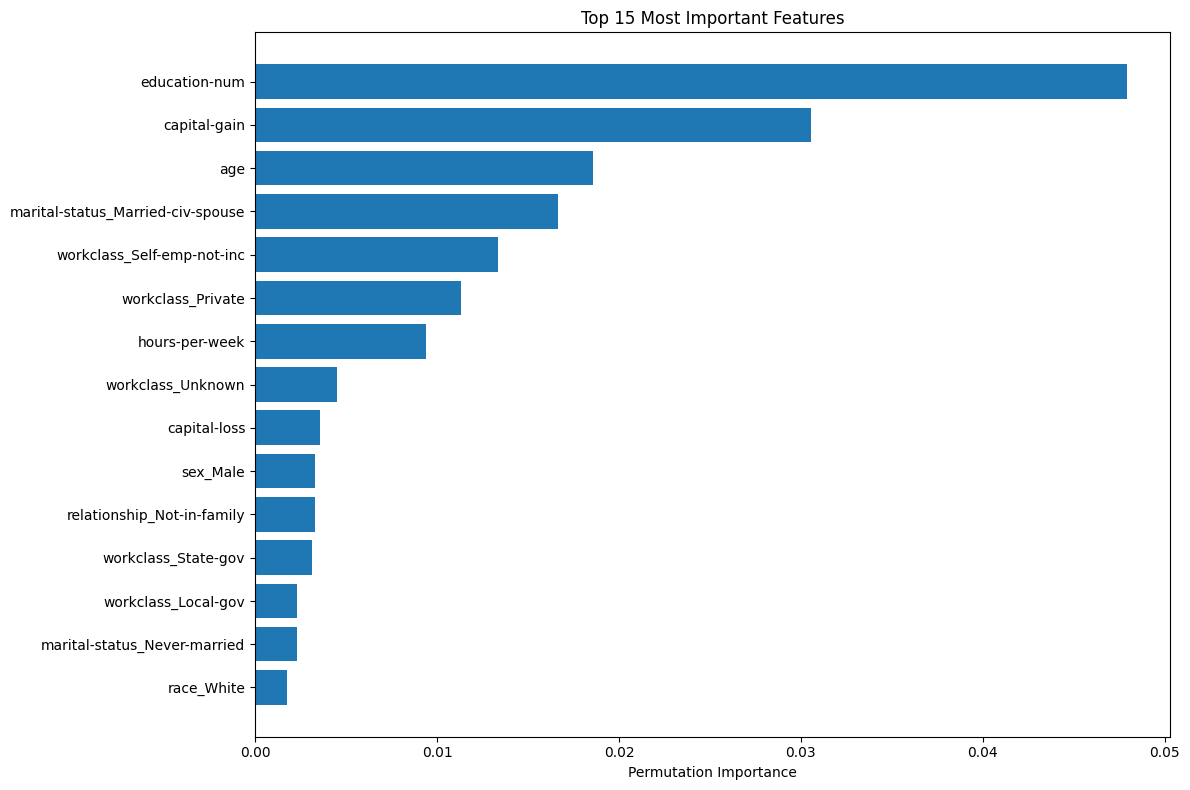


Top 10 Most Important Features:
                              feature  importance
2                       education-num    0.047905
3                        capital-gain    0.030572
0                                 age    0.018561
16  marital-status_Married-civ-spouse    0.016651
10         workclass_Self-emp-not-inc    0.013375
8                   workclass_Private    0.011328
5                      hours-per-week    0.009417
13                  workclass_Unknown    0.004504
4                        capital-loss    0.003549
31                           sex_Male    0.003276

=== FINAL SUMMARY ===
Final Test Accuracy: 0.8574
Final Test Precision: 0.7550
Final Test Recall: 0.5978
Final Test F1-Score: 0.6673
Total Parameters: 4,737
Trainable Parameters: 4,737


In [24]:
def main():
    print("NEURAL NETWORK INCOME CLASSIFICATION")
    print("Building a complete neural network from scratch using PyTorch")

    runner = ExperimentRunner()


    preprocessor = DataPreprocessor()
    X, y = preprocessor.load_data()

    best_preprocessing, prep_results = runner.preprocessing_ablation(X, y)

    print(f"APPLYING BEST PREPROCESSING: {best_preprocessing}")

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

    preprocessor = DataPreprocessor()
    X_train = preprocessor.handle_missing_values(X_train)
    X_val = preprocessor.handle_missing_values(X_val)
    X_test = preprocessor.handle_missing_values(X_test)

    X_train_enc, X_val_enc, X_test_enc = preprocessor.encode_categorical_features(
        X_train, X_val, X_test)

    X_train_final, X_val_final, X_test_final = preprocessor.scale_features(
        X_train_enc, X_val_enc, X_test_enc, method=best_preprocessing['scaling'])

    print(f"Final dataset shapes:")
    print(f"Train: {X_train_final.shape}, Val: {X_val_final.shape}, Test: {X_test_final.shape}")


    best_arch, arch_results = runner.architecture_ablation(X_train_final, X_val_final, y_train, y_val)


    best_optimizer, opt_results = runner.optimizer_ablation(X_train_final, X_val_final, y_train, y_val, best_arch)

    best_reg, reg_results = runner.regularization_ablation(X_train_final, X_val_final, y_train, y_val, best_arch, best_optimizer)


    print("TRAINING FINAL MODEL WITH BEST CONFIGURATION")
    print(f"Best preprocessing: {best_preprocessing}")
    print(f"Best architecture: {best_arch}")
    print(f"Best optimizer: {best_optimizer}")
    print(f"Best regularization: {best_reg}")

    X_train_tensor = torch.FloatTensor(X_train_final)
    X_val_tensor = torch.FloatTensor(X_val_final)
    X_test_tensor = torch.FloatTensor(X_test_final)
    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)
    y_test_tensor = torch.LongTensor(y_test.values)


    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


    final_model = FeedforwardNN(
        X_train_final.shape[1],
        best_arch['hidden_sizes'],
        activation=best_arch['activation'],
        dropout_rate=best_reg['dropout'],
        use_batchnorm=best_reg['batchnorm']
    )


    if best_optimizer['optimizer'] == 'Adam':
        optimizer = optim.Adam(final_model.parameters(), lr=best_optimizer['lr'], weight_decay=best_reg['weight_decay'])
    elif best_optimizer['optimizer'] == 'SGD':
        optimizer = optim.SGD(final_model.parameters(), lr=best_optimizer['lr'], weight_decay=best_reg['weight_decay'])
    elif best_optimizer['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(final_model.parameters(), lr=best_optimizer['lr'], weight_decay=best_reg['weight_decay'])

    criterion = nn.BCELoss()

    final_trainer = ModelTrainer(final_model, runner.device)
    final_model_trained = final_trainer.train(train_loader, val_loader, optimizer, criterion, epochs=100, early_stopping_patience=15)

    plot_results(final_trainer, "Final Model Training")


    test_results = evaluate_model_comprehensive(final_model_trained, test_loader)

    print("HYPERPARAMETER TUNING SUMMARY")


    print("\nPreprocessing Results:")
    prep_df = pd.DataFrame([{
        'scaling': r['scaling'],
        'val_accuracy': r['val_accuracy']
    } for r in prep_results])
    print(prep_df.sort_values('val_accuracy', ascending=False))

    print("\nArchitecture Results:")
    arch_df = pd.DataFrame([{
        'hidden_sizes': str(r['architecture']['hidden_sizes']),
        'activation': r['architecture']['activation'],
        'val_accuracy': r['val_accuracy'],
        'num_params': r['num_params']
    } for r in arch_results])
    print(arch_df.sort_values('val_accuracy', ascending=False))

    print("\nOptimizer Results:")
    opt_df = pd.DataFrame([{
        'optimizer': r['config']['optimizer'],
        'lr': r['config']['lr'],
        'loss': r['config']['loss'],
        'val_accuracy': r['val_accuracy']
    } for r in opt_results])
    print(opt_df.sort_values('val_accuracy', ascending=False))

    print("\nRegularization Results:")
    reg_df = pd.DataFrame([{
        'dropout': r['config']['dropout'],
        'weight_decay': r['config']['weight_decay'],
        'batchnorm': r['config']['batchnorm'],
        'val_accuracy': r['val_accuracy']
    } for r in reg_results])
    print(reg_df.sort_values('val_accuracy', ascending=False))


    print("FEATURE IMPORTANCE ANALYSIS")
    feature_importance_analysis(final_model_trained, X_test_tensor, y_test_tensor, X_train_enc.columns)


    print("FINAL SUMMARY")
    print(f"Final Test Accuracy: {test_results['accuracy']:.4f}")
    print(f"Final Test Precision: {test_results['precision']:.4f}")
    print(f"Final Test Recall: {test_results['recall']:.4f}")
    print(f"Final Test F1-Score: {test_results['f1']:.4f}")


    total_params = sum(p.numel() for p in final_model_trained.parameters())
    trainable_params = sum(p.numel() for p in final_model_trained.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

    return {
        'model': final_model_trained,
        'preprocessor': preprocessor,
        'test_results': test_results,
        'best_config': {
            'preprocessing': best_preprocessing,
            'architecture': best_arch,
            'optimizer': best_optimizer,
            'regularization': best_reg
        },
        'ablation_results': {
            'preprocessing': prep_results,
            'architecture': arch_results,
            'optimizer': opt_results,
            'regularization': reg_results
        }
    }

def feature_importance_analysis(model, X_test, y_test, feature_names):
    print("Calculating feature importance using permutation method")

    model.eval()


    with torch.no_grad():
        baseline_outputs = model(X_test)
        baseline_preds = (baseline_outputs.squeeze() > 0.5).float()
        baseline_acc = (baseline_preds == y_test.float()).float().mean().item()

    importances = []

    for i in range(X_test.shape[1]):

        X_permuted = X_test.clone()
        perm_idx = torch.randperm(X_test.shape[0])
        X_permuted[:, i] = X_test[perm_idx, i]

        with torch.no_grad():
            permuted_outputs = model(X_permuted)
            permuted_preds = (permuted_outputs.squeeze() > 0.5).float()
            permuted_acc = (permuted_preds == y_test.float()).float().mean().item()

        importance = baseline_acc - permuted_acc
        importances.append(importance)

    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Permutation Importance')
    plt.title('Top 15 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))

    return feature_importance_df

def bias_analysis(model, X_test, y_test, original_test_data):
    print("BIAS ANALYSIS")

    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predictions = (outputs.squeeze() > 0.5).cpu().numpy()

    if 'sex' in original_test_data.columns:
        print("\nBias Analysis by Gender:")
        for gender in original_test_data['sex'].unique():
            mask = original_test_data['sex'] == gender
            if mask.sum() > 0:
                gender_acc = accuracy_score(y_test[mask], predictions[mask])
                gender_precision = precision_score(y_test[mask], predictions[mask])
                print(f"  {gender}: Accuracy={gender_acc:.4f}, Precision={gender_precision:.4f}")

    if 'race' in original_test_data.columns:
        print("\nBias Analysis by Race:")
        for race in original_test_data['race'].unique():
            mask = original_test_data['race'] == race
            if mask.sum() > 10:
                race_acc = accuracy_score(y_test[mask], predictions[mask])
                race_precision = precision_score(y_test[mask], predictions[mask])
                print(f"  {race}: Accuracy={race_acc:.4f}, Precision={race_precision:.4f}")

class GridSearchTuner:

    def __init__(self, X_train, X_val, y_train, y_val, device='cpu'):
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.device = device
        self.results = []

    def grid_search(self):
        print("ADVANCED GRID SEARCH")

        param_grid = {
            'hidden_sizes': [[64], [128], [64, 32], [128, 64], [256, 128, 64]],
            'learning_rate': [0.001, 0.01, 0.0001],
            'batch_size': [64, 128, 256],
            'dropout_rate': [0.1, 0.2, 0.3, 0.5]
        }

        total_combinations = (len(param_grid['hidden_sizes']) *
                            len(param_grid['learning_rate']) *
                            len(param_grid['batch_size']) *
                            len(param_grid['dropout_rate']))

        print(f"Total combinations to test: {total_combinations}")

        best_score = 0
        best_params = None

        combination_count = 0

        for hidden_sizes in param_grid['hidden_sizes']:
            for lr in param_grid['learning_rate']:
                for batch_size in param_grid['batch_size']:
                    for dropout in param_grid['dropout_rate']:
                        combination_count += 1

                        if combination_count % 10 == 0:
                            print(f"Testing combination {combination_count}/{total_combinations}")

                        params = {
                            'hidden_sizes': hidden_sizes,
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'dropout_rate': dropout
                        }

                        score = self.train_and_evaluate(params)

                        result = {
                            'params': params,
                            'score': score
                        }
                        self.results.append(result)

                        if score > best_score:
                            best_score = score
                            best_params = params

        print(f"\nBest parameters: {best_params}")
        print(f"Best validation score: {best_score:.4f}")


        results_df = pd.DataFrame([{
            'hidden_sizes': str(r['params']['hidden_sizes']),
            'learning_rate': r['params']['learning_rate'],
            'batch_size': r['params']['batch_size'],
            'dropout_rate': r['params']['dropout_rate'],
            'val_accuracy': r['score']
        } for r in self.results])

        print("\nTop 10 configurations:")
        print(results_df.sort_values('val_accuracy', ascending=False).head(10))

        return best_params, results_df

    def train_and_evaluate(self, params):
        X_train_tensor = torch.FloatTensor(self.X_train)
        X_val_tensor = torch.FloatTensor(self.X_val)
        y_train_tensor = torch.LongTensor(self.y_train.values)
        y_val_tensor = torch.LongTensor(self.y_val.values)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)


        model = FeedforwardNN(
            self.X_train.shape[1],
            params['hidden_sizes'],
            activation='relu',
            dropout_rate=params['dropout_rate']
        )

        trainer = ModelTrainer(model, self.device)
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.BCELoss()


        trained_model = trainer.train(train_loader, val_loader, optimizer, criterion,
                                    epochs=30, early_stopping_patience=5)

        _, val_acc, _, _ = trainer.evaluate(val_loader, criterion)

        return val_acc

if __name__ == "__main__":
    results = main()